In [36]:
import numpy as np
import networkx as nx
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import heapq

# -----------------------------------------------------------
# 1. Greedy k successive matchings (Hungarian + deletion)
# -----------------------------------------------------------

def greedy_k_matchings(W, k):
    n = W.shape[0]
    W_curr = W.copy().astype(float)

    matchings = []
    total_weight = 0.0

    for _ in range(k):
        # Hungarian solves *min*-cost; convert to max-cost
        row, col = linear_sum_assignment(-W_curr)
        M = list(zip(row, col))
        matchings.append(M)
        total_weight += W_curr[row, col].sum()

        # "Delete" used edges
        for i, j in M:
            W_curr[i, j] = -1e15

    return total_weight, matchings

# -----------------------------------------------------------
# 2. Optimal solution via min-cost flow
# -----------------------------------------------------------

def optimal_k_matchings_via_mcf(W, k):
    n = W.shape[0]
    G = nx.DiGraph()

    # Source -> left
    for i in range(n):
        G.add_edge("s", f"L{i}", capacity=k, weight=0)

    # Left -> Right edges
    for i in range(n):
        for j in range(n):
            G.add_edge(f"L{i}", f"R{j}", capacity=1, weight=-W[i, j])

    # Right -> sink
    for j in range(n):
        G.add_edge(f"R{j}", "t", capacity=k, weight=0)

    # Required total flow = k * n
    flow = nx.max_flow_min_cost(G, "s", "t")

    chosen_edges = []
    for i in range(n):
        for j in range(n):
            if flow[f"L{i}"][f"R{j}"] > 0:
                chosen_edges.append((i, j))

    total_weight = sum(W[i, j] for (i, j) in chosen_edges)

    # -------------------------------------------------------
    # Decompose into k matchings
    # -------------------------------------------------------
    H = nx.Graph()
    for (i, j) in chosen_edges:
        H.add_edge(f"L{i}", f"R{j}")

    matchings = []
    Hcopy = H.copy()

    for _ in range(k):
        M = nx.algorithms.matching.max_weight_matching(
            Hcopy, maxcardinality=True
        )
        Mpairs = []
        for u, v in M:
            if u.startswith("L"):
                i = int(u[1:])
                j = int(v[1:])
            else:
                i = int(v[1:])
                j = int(u[1:])
            Mpairs.append((i, j))
        matchings.append(Mpairs)
        Hcopy.remove_edges_from(M)

    return total_weight, matchings

# -----------------------------------------------------------
# 3. Comparison helpers: sweep k=1..n and plot
# -----------------------------------------------------------

def sweep_weights_over_k(W):
    n = W.shape[0]
    # Greedy (incremental): O(n) Hungarian runs total
    greedy_vals = []
    W_curr = W.copy().astype(float)
    total_g = 0.0
    for k in range(1, n + 1):
        row, col = linear_sum_assignment(-W_curr)
        total_g += float(W_curr[row, col].sum())
        greedy_vals.append(total_g)
        W_curr[row, col] = -1e15

    # Optimal via one successive-shortest-path sweep (records totals after each n units)
    opt_vals = _optimal_sweep_ssp_total_weights(W)
    return greedy_vals, opt_vals

class MCMF:
    def __init__(self, N):
        self.N = N
        self.g = [[] for _ in range(N)]
        self.pi = [0.0] * N  # potentials
        self.dist = [0.0] * N
        self.par = [(-1, -1)] * N

    def add_edge(self, u, v, cap, cost):
        self.g[u].append([v, cap, cost, len(self.g[v])])
        self.g[v].append([u, 0, -cost, len(self.g[u]) - 1])

    def shortest_path(self, s):
        N = self.N
        INF = 1e100
        self.dist = [INF] * N
        self.par = [(-1, -1)] * N
        self.dist[s] = 0.0

        pq = [(0.0, s)]
        while pq:
            d, u = heapq.heappop(pq)
            if d != self.dist[u]:
                continue
            for ei, e in enumerate(self.g[u]):
                v, cap, cost, rev = e
                if cap <= 0:
                    continue
                rc = cost + self.pi[u] - self.pi[v]
                nd = d + rc
                if nd < self.dist[v]:
                    self.dist[v] = nd
                    self.par[v] = (u, ei)
                    heapq.heappush(pq, (nd, v))

        # update potentials
        for i in range(N):
            if self.dist[i] < 1e100:
                self.pi[i] += self.dist[i]

    def maxflow(self, s, t):
        flow = 0
        cost = 0.0
        INF = 1 << 60

        while True:
            self.shortest_path(s)
            if self.dist[t] > 1e50:
                break

            # find bottleneck
            f = INF
            v = t
            while v != s:
                u, ei = self.par[v]
                _, cap, _, _ = self.g[u][ei]
                f = min(f, cap)
                v = u

            # push flow
            v = t
            while v != s:
                u, ei = self.par[v]
                to, cap, cst, rev = self.g[u][ei]
                self.g[u][ei][1] -= f
                self.g[v][rev][1] += f
                cost += cst * f
                v = u

            flow += f

        return flow, cost

def _optimal_sweep_ssp_total_weights(W):
    # Reimplemented using MCMF with staged capacities
    n = W.shape[0]
    N = 2 * n + 2
    s, t = 2 * n, 2 * n + 1
    m = MCMF(N)

    # s -> L with initial cap 1 (store edge indices to unlock later)
    s_edge_idx = []
    for i in range(n):
        idx = len(m.g[s])
        m.add_edge(s, i, 1, 0.0)
        s_edge_idx.append(idx)

    # L -> R edges with cap 1 and cost = -W
    for i in range(n):
        for j in range(n):
            m.add_edge(i, n + j, 1, -float(W[i, j]))

    # R -> t with initial cap 1 (store edge indices to unlock later)
    t_edge_idx = []
    for j in range(n):
        u = n + j
        idx = len(m.g[u])
        m.add_edge(u, t, 1, 0.0)
        t_edge_idx.append(idx)

    opt_vals = []
    total_cost = 0.0

    # First block (k=1): push n units
    f, c = m.maxflow(s, t)
    total_cost += c
    opt_vals.append(float(-total_cost))

    # Unlock capacities and push next blocks for k=2..n
    for _ in range(2, n + 1):
        for i in range(n):
            m.g[s][s_edge_idx[i]][1] += 1
        for j in range(n):
            u = n + j
            m.g[u][t_edge_idx[j]][1] += 1
        f, c = m.maxflow(s, t)
        total_cost += c
        opt_vals.append(float(-total_cost))

    return opt_vals

def plot_comparison(n, seed=0):
    rng = np.random.default_rng(seed)
    W = rng.random((n, n))
    greedy_vals, opt_vals = sweep_weights_over_k(W)
    ks = np.arange(1, n + 1)
    plt.figure(figsize=(6, 4))
    plt.plot(ks, greedy_vals, marker='o', label='Greedy total weight')
    plt.plot(ks, opt_vals, marker='s', label='Optimal total weight')
    plt.xlabel('k')
    plt.ylabel('Total weight')
    plt.title(f'Greedy vs Optimal over k=1..{n}')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def sweep_weights_over_k_trials(n, num_trials=10, seed=0):
    """Run multiple trials and aggregate greedy/optimal totals over k=1..n."""
    greedy_trials = np.empty((num_trials, n), dtype=float)
    opt_trials = np.empty((num_trials, n), dtype=float)
    ss = np.random.SeedSequence(seed)
    children = ss.spawn(num_trials)
    for t in range(num_trials):
        rng = np.random.default_rng(children[t])
        W = rng.random((n, n))
        g_vals, o_vals = sweep_weights_over_k(W)
        greedy_trials[t, :] = g_vals
        opt_trials[t, :] = o_vals
    ks = np.arange(1, n + 1)
    g_mean = greedy_trials.mean(axis=0)
    o_mean = opt_trials.mean(axis=0)
    g_std = greedy_trials.std(axis=0, ddof=0)
    o_std = opt_trials.std(axis=0, ddof=0)
    return ks, g_mean, o_mean, g_std, o_std

def plot_comparison_trials(n, num_trials=10, seed=0, show_std=True):
    """Plot mean totals over num_trials; optionally shade ±1 std."""
    ks, g_mean, o_mean, g_std, o_std = sweep_weights_over_k_trials(n, num_trials, seed)
    plt.figure(figsize=(6, 4))
    plt.plot(ks, g_mean, marker='o', label=f'Greedy mean (T={num_trials})')
    plt.plot(ks, o_mean, marker='s', label=f'Optimal mean (T={num_trials})')
    plt.xlabel('k')
    plt.ylabel('Total weight')
    plt.title(f'Greedy vs Optimal means over k=1..{n} (num_trials={num_trials})')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return {
        'ks': ks,
        'greedy_mean': g_mean, 'optimal_mean': o_mean,
        'greedy_std': g_std, 'optimal_std': o_std
    }

In [37]:
plot_comparison(20)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Naman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Naman\AppData\Local\Temp\ipykernel_17360\3988787224.py", line 1, in <module>
    plot_comparison(20)
  File "C:\Users\Naman\AppData\Local\Temp\ipykernel_17360\2579485329.py", line 235, in plot_comparison
    greedy_vals, opt_vals = sweep_weights_over_k(W)
                            ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Naman\AppData\Local\Temp\ipykernel_17360\2579485329.py", line 108, in sweep_weights_over_k
    opt_vals = _optimal_sweep_ssp_total_weights(W)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Naman\AppData\Local\Temp\ipykernel_17360\2579485329.py", line 226, in _optimal_sweep_ssp_total_weights
    f, c = m.maxflow(s, t)
           ^^^^^^^^^^^^^

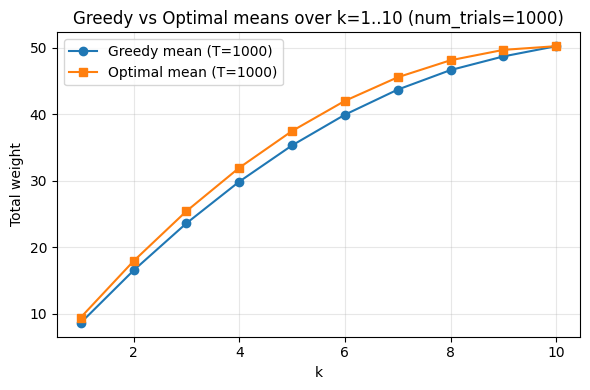

Greedy mean for k=1: 8.650131
Optimal mean for k=1: 9.453912


In [ ]:
# Averaged plot over multiple trials + print k=1 means
res = plot_comparison_trials(10, num_trials=1000)
print(f"Greedy mean for k=1: {res['greedy_mean'][0]:.6f}")
print(f"Optimal mean for k=1: {res['optimal_mean'][0]:.6f}")